In [ ]:
!sudo rm -rf /content/sample_data

In [ ]:
!curl -L -o /content/archive.zip https://www.kaggle.com/api/v1/datasets/download/rupakroy/urban-sound-8k
!unzip /content/archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-10.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-11.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-12.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-13.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-14.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-15.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-16.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-17.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-18.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-19.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-2.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0

In [ ]:
!sudo rm -rf /content/archive.zip
!sudo rm -rf /content/UrbanSound8K.csv
!sudo rm -rf /content/UrbanSound8K_README.txt

In [ ]:
import pandas as pd

# Load the metadata CSV
csv_file_path = '/content/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv'  # Replace with the path to UrbanSound8K.csv
metadata = pd.read_csv(csv_file_path)

# Find unique class names and their corresponding numbers
unique_classes = metadata[['classID', 'class']].drop_duplicates().sort_values(by='classID').reset_index(drop=True)

# Display the unique classes and their IDs
print("Unique classes and their corresponding class IDs:")
print(unique_classes)


Unique classes and their corresponding class IDs:
   classID             class
0        0   air_conditioner
1        1          car_horn
2        2  children_playing
3        3          dog_bark
4        4          drilling
5        5     engine_idling
6        6          gun_shot
7        7        jackhammer
8        8             siren
9        9      street_music


In [ ]:
classes_to_keep = [0,2,3,4,6,8,9]

In [ ]:
import pandas as pd
import numpy as np
import librosa
import os

def load_filtered_metadata(csv_file_path, classes_to_keep):
    # Load the metadata CSV file
    metadata = pd.read_csv(csv_file_path)
    # Filter the metadata to keep only the specified classes
    filtered_metadata = metadata[metadata['classID'].isin(classes_to_keep)]
    return filtered_metadata


In [ ]:
!pip install librosa

In [ ]:
def convert_to_mfcc_with_filtered_labels(audio_dir, metadata, max_pad_len=200):
    # Initialize dataset list
    dataset = []

    for index, row in metadata.iterrows():
        # Build file path
        file_name = row['slice_file_name']
        fold = row['fold']
        label = row['classID']
        file_path = os.path.join(audio_dir, f'fold{fold}', file_name)

        # Load the audio file
        try:
            audio, sr = librosa.load(file_path)

            # Convert to MFCC
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

            # Pad or truncate MFCCs to ensure uniform shape
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            # Append (features, label) as a tuple to the dataset list
            dataset.append((mfccs, label))

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue

    # Convert dataset list to a NumPy array
    return np.array(dataset, dtype=object)


# Paths
audio_dir = '/content/UrbanSound8K/UrbanSound8K/audio'  # Replace with the path to the UrbanSound8K audio directory

# Load filtered metadata and create the dataset
filtered_metadata = load_filtered_metadata(csv_file_path, classes_to_keep)
dataset = convert_to_mfcc_with_filtered_labels(audio_dir, filtered_metadata)

# Check dataset shape and structure
print("Filtered dataset shape:", dataset.shape)
print("First element (MFCCs, Label):", dataset[0])


Filtered dataset shape: (6303, 2)
First element (MFCCs, Label): [array([[-332.0388   , -169.58775  ,  -90.246826 , ...,    0.       ,
            0.       ,    0.       ],
        [ 119.39658  ,   83.29506  ,   61.68872  , ...,    0.       ,
            0.       ,    0.       ],
        [-102.87578  , -120.09383  , -129.49957  , ...,    0.       ,
            0.       ,    0.       ],
        ...,
        [  12.779535 ,    3.5483198,   -6.067363 , ...,    0.       ,
            0.       ,    0.       ],
        [  -3.7113366,  -11.908623 ,   -5.7381015, ...,    0.       ,
            0.       ,    0.       ],
        [ -21.403109 ,  -27.239983 ,  -21.73337  , ...,    0.       ,
            0.       ,    0.       ]], dtype=float32)                 3]


In [ ]:
# Convert dataset to separate features and labels arrays
features = np.array([sample[0] for sample in dataset], dtype=np.float32)  # Shape: (6732, n_mfcc, max_pad_len)
labels = np.array([sample[1] for sample in dataset], dtype=int)           # Shape: (6732,)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (6303, 13, 200)
Labels shape: (6303,)


In [ ]:
# Counting unique labels and their occurrences
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the counts of each label
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 6, Count: 374
Label: 8, Count: 929
Label: 9, Count: 1000


In [ ]:
!curl -L -o /content/gunshot.zip https://www.kaggle.com/api/v1/datasets/download/emrahaydemr/gunshot-audio-dataset
!unzip /content/gunshot.zip -d /content/Gunshot
!sudo rm -rf /content/gunshot.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  380M  100  380M    0     0  17.7M      0  0:00:21  0:00:21 --:--:-- 19.4M
Archive:  /content/gunshot.zip
  inflating: /content/Gunshot/AK-12/3 (1).wav  
  inflating: /content/Gunshot/AK-12/3 (10).wav  
  inflating: /content/Gunshot/AK-12/3 (11).wav  
  inflating: /content/Gunshot/AK-12/3 (12).wav  
  inflating: /content/Gunshot/AK-12/3 (13).wav  
  inflating: /content/Gunshot/AK-12/3 (14).wav  
  inflating: /content/Gunshot/AK-12/3 (15).wav  
  inflating: /content/Gunshot/AK-12/3 (16).wav  
  inflating: /content/Gunshot/AK-12/3 (17).wav  
  inflating: /content/Gunshot/AK-12/3 (18).wav  
  inflating: /content/Gunshot/AK-12/3 (19).wav  
  inflating: /content/Gunshot/AK-12/3 (2).wav  
  inflating: /content/Gunshot/AK-12/3 (20).wav  
  inflating: /cont

In [ ]:
import os
import librosa
import numpy as np

# Path to the main folder containing gunshot subfolders
gunshot_main_folder = '/content/Gunshot'  # Replace with actual path
gunshot_label_id = 6  # Label ID for gunshot as per UrbanSound8K's classID

# Parameters for MFCC extraction
n_mfcc = 13
max_pad_len = 200

# Ensure dataset is a list initially
dataset = dataset.tolist() if isinstance(dataset, np.ndarray) else dataset

# Function to process and add gunshot files from multiple subfolders
def add_combined_gunshots_to_dataset(main_folder, label_id, dataset):
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Skip if it's not a directory
        if not os.path.isdir(subfolder_path):
            continue

        # Process each file in the subfolder
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)

            # Load audio and compute MFCCs
            audio, sr = librosa.load(file_path)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            # Pad or truncate MFCCs to ensure uniform shape
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            # Append the MFCC and label tuple to the dataset list
            dataset.append((mfccs, label_id))

# Call the function to add gunshot data from all subfolders
add_combined_gunshots_to_dataset(gunshot_main_folder, gunshot_label_id, dataset)

# Convert dataset to NumPy array if needed
dataset = np.array(dataset, dtype=object)  # dtype=object due to mixed types (MFCC array and label)

print("Updated dataset shape:", dataset.shape)


Updated dataset shape: (7154, 2)


In [ ]:
# Convert dataset to separate features and labels arrays
features = np.array([sample[0] for sample in dataset], dtype=np.float32)  # Shape: (6732, n_mfcc, max_pad_len)
labels = np.array([sample[1] for sample in dataset], dtype=int)           # Shape: (6732,)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (7154, 13, 200)
Labels shape: (7154,)


In [ ]:
# Counting unique labels and their occurrences
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the counts of each label
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 6, Count: 1225
Label: 8, Count: 929
Label: 9, Count: 1000


In [ ]:
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define the ratios for train, validation, and test splits
# train_ratio = 0.7
# valid_ratio = 0.15
# test_ratio = 0.15

# # Split dataset into train and temp
# X_train, X_temp, y_train, y_temp = train_test_split(
#     features,
#     labels,
#     test_size=(1 - train_ratio),
#     stratify=labels,
#     random_state=42
# )

# # Then split temp into validation and test
# test_size_ratio = test_ratio / (test_ratio + valid_ratio)
# X_valid, X_test, y_valid, y_test = train_test_split(
#     X_temp,
#     y_temp,
#     test_size=test_size_ratio,
#     stratify=y_temp,
#     random_state=42
# )

# # Check the shapes of each set
# print("Training set shape:", X_train.shape, y_train.shape)
# print("Validation set shape:", X_valid.shape, y_valid.shape)
# print("Test set shape:", X_test.shape, y_test.shape)

# # Check label distribution in each set
# def check_class_distribution(labels, name):
#     unique_labels, counts = np.unique(labels, return_counts=True)
#     print(f"\n{name} Set Class Distribution:")
#     for label, count in zip(unique_labels, counts):
#         print(f"Label: {label}, Count: {count}")

# check_class_distribution(y_train, "Training")
# check_class_distribution(y_valid, "Validation")
# check_class_distribution(y_test, "Test")

Training set shape: (5007, 13, 200) (5007,)
Validation set shape: (1073, 13, 200) (1073,)
Test set shape: (1074, 13, 200) (1074,)

Training Set Class Distribution:
Label: 0, Count: 700
Label: 2, Count: 700
Label: 3, Count: 700
Label: 4, Count: 700
Label: 6, Count: 857
Label: 8, Count: 650
Label: 9, Count: 700

Validation Set Class Distribution:
Label: 0, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 150
Label: 6, Count: 184
Label: 8, Count: 139
Label: 9, Count: 150

Test Set Class Distribution:
Label: 0, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 150
Label: 6, Count: 184
Label: 8, Count: 140
Label: 9, Count: 150


In [ ]:
!pip install numpy tensorflow scikit-learn matplotlib seaborn pandas

# Verify GPU
import tensorflow as tf
print("\nGPU Information:")
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
print("\nNumber of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


GPU Information:
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.17.0

Number of GPUs Available:  1


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def create_label_mapping():
    """Create mapping from original labels to consecutive integers"""
    original_labels = [0, 2, 3, 4, 6, 8, 9]  # Original non-consecutive labels
    return {original: new for new, original in enumerate(original_labels)}

def get_original_labels():
    """Get the mapping from consecutive integers back to original labels"""
    mapping = create_label_mapping()
    reverse_mapping = {v: k for k, v in mapping.items()}
    return [reverse_mapping[i] for i in range(len(mapping))]

def remap_labels(labels):
    """Convert non-consecutive labels to consecutive integers"""
    mapping = create_label_mapping()
    return np.array([mapping[label] for label in labels])

In [ ]:
def split_data(features, labels, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15):
    """
    Split the dataset into train, validation, and test sets with stratification.
    """
    # First remap the labels
    remapped_labels = remap_labels(labels)

    # Split dataset into train and temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        features,
        remapped_labels,
        test_size=(1 - train_ratio),
        stratify=remapped_labels,
        random_state=42
    )

    # Then split temp into validation and test
    test_size_ratio = test_ratio / (test_ratio + valid_ratio)
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=test_size_ratio,
        stratify=y_temp,
        random_state=42
    )

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
def prepare_data(X_train, X_valid, X_test, y_train, y_valid, y_test):
    """
    Convert labels to categorical (one-hot encoded).
    """
    num_classes = 7  # We have 7 classes (0-6)
    y_train_cat = to_categorical(y_train, num_classes)
    y_valid_cat = to_categorical(y_valid, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    return X_train, X_valid, X_test, y_train_cat, y_valid_cat, y_test_cat


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

def create_lstm_model(input_shape, num_classes=7):
    """
    Create and compile an enhanced LSTM model.
    """
    model = Sequential()

    # First Bidirectional LSTM layer with Batch Normalization and Dropout
    model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fourth Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=64)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Dense layer for additional learning capacity
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
def train_model(X_train, y_train, X_valid, y_valid, epochs=50, batch_size=32):
    """
    Train the LSTM model with early stopping and model checkpointing.
    """
    # Create the model
    model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min'
    )

    # Model checkpoint callback
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    return model, history


In [ ]:
def plot_training_history(history):
    """
    Plot training and validation loss/accuracy curves.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def check_class_distribution(labels, name):
    """
    Print class distribution for a given set of labels.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} Set Class Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Label: {label}, Count: {count}")

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and display results using original label values.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Get original class names
    original_labels = get_original_labels()
    class_names = [str(label) for label in original_labels]

    # Convert back to original labels for the classification report
    y_pred_original = np.array([original_labels[i] for i in y_pred_classes])
    y_test_original = np.array([original_labels[i] for i in y_test_classes])

    # Print classification report
    print('\nClassification Report:')
    print(classification_report(y_test_original, y_pred_original))

    # Plot confusion matrix
    plot_confusion_matrix(y_test_classes, y_pred_classes, class_names)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [ ]:
# Assuming features and labels are your input data
# features shape: (n_samples, 13, 200)
# labels: array with values [0,2,3,4,6,8,9]

# Split the data (includes label remapping)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(
    features, labels
)

# Check data shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (5007, 13, 200) (5007,)
Validation set shape: (1073, 13, 200) (1073,)
Test set shape: (1074, 13, 200) (1074,)


In [ ]:

# Check class distributions (now showing remapped labels 0-6)
check_class_distribution(y_train, "Training")
check_class_distribution(y_valid, "Validation")
check_class_distribution(y_test, "Test")

# Convert to categorical (one-hot encoding)
X_train_prep, X_valid_prep, X_test_prep, y_train_prep, y_valid_prep, y_test_prep = prepare_data(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test
)


Training Set Class Distribution:
Label: 0, Count: 700
Label: 1, Count: 700
Label: 2, Count: 700
Label: 3, Count: 700
Label: 4, Count: 857
Label: 5, Count: 650
Label: 6, Count: 700

Validation Set Class Distribution:
Label: 0, Count: 150
Label: 1, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 184
Label: 5, Count: 139
Label: 6, Count: 150

Test Set Class Distribution:
Label: 0, Count: 150
Label: 1, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 184
Label: 5, Count: 140
Label: 6, Count: 150


In [ ]:
y_train_prep[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.2879 - loss: 2.1002 - val_accuracy: 0.5042 - val_loss: 1.3557
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4512 - loss: 1.4595 - val_accuracy: 0.5405 - val_loss: 1.2245
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4821 - loss: 1.3395 - val_accuracy: 0.5573 - val_loss: 1.1512
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5175 - loss: 1.2707 - val_accuracy: 0.5788 - val_loss: 1.1724
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5668 - loss: 1.1650 - val_accuracy: 0.6048 - val_loss: 1.1116
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5875 - loss: 1.1107 - val_accuracy: 0.5918 - val_loss: 1.0982
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6150 - loss: 1.0666 - val_accuracy: 0.6365 - val_loss: 1.0172
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6256 - loss: 1.0092 -

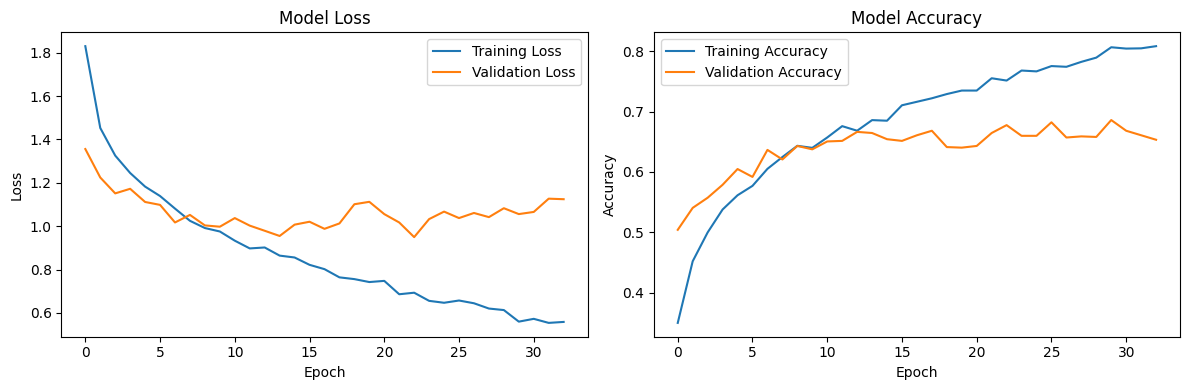

In [ ]:
# Train the model
model, history = train_model(
    X_train_prep, y_train_prep,
    X_valid_prep, y_valid_prep,
    epochs=100,
    batch_size=32
)

# Plot training history
plot_training_history(history)

In [ ]:
model.summary

<bound method Model.summary of <Sequential name=sequential_1, built=True>>

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       150
           2       0.48      0.37      0.42       150
           3       0.73      0.49      0.59       150
           4       0.60      0.73      0.66       150
           6       0.92      0.92      0.92       184
           8       0.65      0.78      0.71       140
           9       0.45      0.55      0.49       150

    accuracy                           0.66      1074
   macro avg       0.66      0.65      0.65      1074
weighted avg       0.67      0.66      0.66      1074



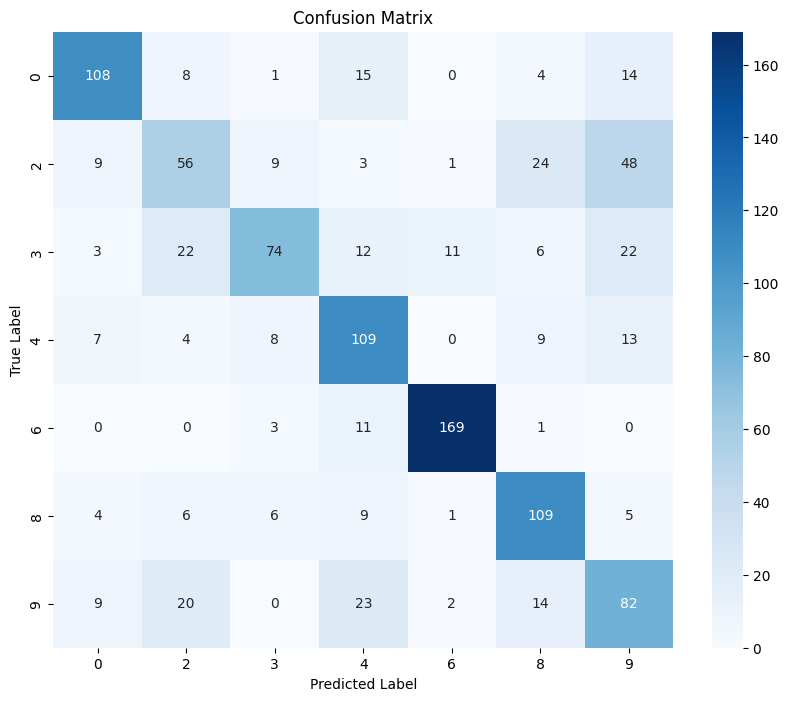

In [ ]:


# Evaluate model
evaluate_model(model, X_test_prep, y_test_prep)

# Save the final model
model.save('final_lstm_model.h5')


In [ ]:
X_train_prep.shape

(5007, 13, 200)

# New section

In [ ]:
# Unique classes and their corresponding class IDs:
#    classID             class
# 0        0   air_conditioner
# 1        1          car_horn  NA
# 2        2  children_playing
# 3        3          dog_bark
# 4        4          drilling
# 5        5     engine_idling  NA
# 6        6          gun_shot
# 7        7        jackhammer  NA
# 8        8             siren
# 9        9      street_music

In [ ]:
import tensorflow as tf
import librosa
import numpy as np

def extract_mfcc_features(audio_path):
    """
    Extract MFCC features from an audio file.
    Returns features of shape (13, 200) through padding or truncating.
    """
    # Load audio file
    y, sr = librosa.load(audio_path)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Pad or truncate to 200 time steps
    if mfcc.shape[1] < 200:
        # Pad with zeros if shorter
        pad_width = ((0, 0), (0, 200 - mfcc.shape[1]))
        mfcc = np.pad(mfcc, pad_width, mode='constant')
    else:
        # Truncate if longer
        mfcc = mfcc[:, :200]

    return mfcc

def detect_gunshot(audio_path, model_path):
    """
    Detect gunshot in audio file using the trained Keras model.
    Returns predicted class and probability.
    """
    # Load the Keras model
    # model = tf.keras.models.load_model(model_path)

    # Extract features
    features = extract_mfcc_features(audio_path)

    # Reshape features to fit model input shape (1, 13, 200) for one sample
    features = np.expand_dims(features, axis=0)  # Shape: (1, 13, 200)

    # Get prediction
    predictions = model.predict(features)

    # Get predicted class and confidence
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)

    # Map back to original labels (assuming the same mapping as in training)
    # [0, 2, 3, 4, 6, 8, 9]
    label_map = {
        0:1,
        1:2,
        2:3,
        3:4,
        4:6,
        5:8,
        6:9
    }
    original_label = label_map.get(predicted_class, predicted_class)

    return original_label, confidence

def process_audio_file(audio_path, model_path):
    """
    Process an audio file and print the detection results.
    """
    # Detect gunshot
    predicted_class, confidence = detect_gunshot(audio_path, model_path)

    # Print results
    print(f"Audio file: {audio_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

# Example usage
audio_file = '/content/samples/sample.wav'
model_path = '/content/d1_lstm_model.h5'
process_audio_file(audio_file, model_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Audio file: /content/samples/sample.wav
Predicted class: 9
Confidence: 84.63%


In [ ]:

audio_file = '/content/samples/Dog Barking Sound Effect - Copyright free [TubeRipper.com].wav'
model_path = '/content/d1_lstm_model.h5'
process_audio_file(audio_file, model_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Audio file: /content/samples/Dog Barking Sound Effect - Copyright free [TubeRipper.com].wav
Predicted class: 3
Confidence: 86.61%


In [ ]:

audio_file = '/content/samples/Gunshot Sound Effect Single Shot [TubeRipper.com].wav'
model_path = '/content/d1_lstm_model.h5'
process_audio_file(audio_file, model_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Audio file: /content/samples/Gunshot Sound Effect Single Shot [TubeRipper.com].wav
Predicted class: 6
Confidence: 99.99%


In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from kerastuner import Hyperband

def build_model(hp):
    model = Sequential()

    # Tune the number of units in the LSTM layers
    for i in range(hp.Int('num_layers', 2, 4)):  # Number of LSTM layers to try between 2 and 4
        model.add(Bidirectional(LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
            return_sequences=(i < hp.Int('num_layers', 2, 4) - 1),
            kernel_regularizer=l2(hp.Float('l2_reg', 1e-4, 1e-3, sampling='log'))
        )))
        if i < hp.Int('num_layers', 2, 4) - 1:
            model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))

    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_reg_dense', 1e-4, 1e-3, sampling='log'))
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
from kerastuner.tuners import Hyperband

# Initialize the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_epochs=50,
    factor=3,  # This controls the reduction factor in hyperband
    directory='hyperband_tuning',
    project_name='lstm_tuning'
)


Reloading Tuner from hyperband_tuning/lstm_tuning/tuner0.json


In [ ]:
# Assuming you have prepared your data as X_train, y_train, X_valid, y_valid
tuner.search(X_train_prep, y_train_prep, epochs=100, validation_data=(X_valid_prep, y_valid_prep),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)


In [ ]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
